In [2]:
%reset

In [33]:
import torch.utils.data as data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import torch
import abc
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from typing import List
import numpy as np
from sklearn.utils import class_weight

#### Set up criteria for classifying the data

In [4]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

In [5]:
COLUMNS_TO_DUMMY = [
    "HeatingType",
    "AptManageType",
    "HallwayType",
    "TimeToBusStop",
    "TimeToSubway",
    "SubwayStation",
]
OUTPUT_COLUMN = "SalePrice"

# Create a dataset class for classification

In [6]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.headers = list(self.data.columns)
        self._to_tensor()
        self.size = self.data.shape[0]

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns

    def prepare_for_training(self) -> None:
        self.data = self.get_data_as_pandas()
        self._multiply_data()
        self.shuffle()
        self._to_tensor()

    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMNS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(
                    self.data[column].values.reshape(-1, 1)
                )

    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMNS_TO_DUMMY)
        if self.scaler:
            self._scale_data()

    def _to_tensor(self) -> None:
        self.headers = list(self.data.columns)
        self.label = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.float32)
        self.data = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]

    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        df = pd.concat([labels, data], axis=1)
        df.columns = self.headers
        return df

    @abc.abstractmethod
    def _multiply_data(self) -> None:
        return

    
    def shuffle(self):
        self.data.sample(frac=1)

In [7]:
class HouseDatasetClassification(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)
        self._classify_data()

    def _classify_data(self) -> None:
        self.label = torch.where(
            self.label > CRITERIUM_MAX_AVERAGE,
            torch.tensor(2),
            torch.where(
                (self.label > CRITERIUM_MAX_CHEAP)
                & (self.label <= CRITERIUM_MAX_AVERAGE),
                torch.tensor(1),
                torch.tensor(0),
            ),
        )

    def _multiply_data(self) -> None:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(self.data.iloc[:,1:], self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

In [8]:
train_path = "../data/split_train_data/train_data.csv"
val_path = "../data/split_train_data/val_data.csv"
scaler = MinMaxScaler()

In [10]:
train_dataset_classify = HouseDatasetClassification(train_path, scaler)
train_dataset_classify.prepare_for_training()
train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

val_dataset_classify = HouseDatasetClassification(val_path, scaler)
# train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

In [11]:
# Display the data

In [46]:
train_dataset_classify_df

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0.0,0.729730,0.198456,0.380952,0.093969,0.604088,0.384615,0.000000,0.666667,0.8125,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.783784,0.332879,0.190476,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2.0,1.000000,0.353769,0.142857,0.245442,1.000000,0.538462,0.888889,1.000000,0.3750,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.378378,0.200272,0.285714,0.280505,0.000000,0.307692,0.370370,0.222222,1.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.405405,0.597638,0.571429,0.733520,0.405753,0.538462,0.740741,0.333333,0.8750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,2.0,0.783784,0.612171,0.214286,0.009818,0.457986,0.307692,0.185185,0.444444,0.5625,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6011,2.0,0.783784,0.684832,0.857143,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6012,2.0,0.405405,0.738420,0.095238,0.733520,0.405753,0.538462,0.740741,0.333333,0.8750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6013,2.0,0.783784,0.568574,0.904762,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
train_dataset_classify_df.iloc[:, 0].value_counts()

SalePrice
0.0    2005
1.0    2005
2.0    2005
Name: count, dtype: int64

# Classification model

In [13]:
class HousingClassificationModel(nn.Module):
    def __init__(self, input_size: int, class_num: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 56)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(56, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32,  class_num)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        # x = self.bn2(x)
        x = self.fc3(x)
        return x

####  Prepare loaders and set batch size

In [14]:
batch_size = 32
train_loader_classify = data.DataLoader(train_dataset_classify, batch_size=batch_size, shuffle=True)
validation_loader_classify = data.DataLoader(val_dataset_classify, batch_size=batch_size, shuffle=True)

In [41]:
train_dataset_classify.label

tensor([0., 1., 2.,  ..., 2., 2., 2.])

#### Set up the model, optimizer and loss function

In [46]:
model_classify = HousingClassificationModel(input_size=train_dataset_classify.data.shape[1], class_num=3)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.001)
# loss_fn_classify = nn.CrossEntropyLoss(weight=torch.tensor([1.2, 0.9, 1.8]))
loss_fn_classify = nn.CrossEntropyLoss()
mca = MulticlassAccuracy(num_classes=3, average=None)

# Train the model

In [48]:
EPOCHS_NUMBER = 50
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model_classify.train()
    batch_idx = 0
    for data, label in train_loader_classify:
        model_output = model_classify(data).squeeze()
        loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        batch_idx += 1
        train_batch_accuracy_sum += mca(torch.argmax(model_output, dim=1), label)
    mean_error_train = train_batch_loss_sum / len(train_loader_classify)
    train_losses.append(mean_error_train)
    train_batch_accuracy_avg = train_batch_accuracy_sum / batch_idx
    train_accuracies.append(train_batch_accuracy_avg)
    model_classify.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader_classify:
        val_predicts = model_classify(val_inputs).squeeze(dim=1)
        val_loss = loss_fn_classify(val_predicts, val_labels.type(torch.LongTensor))
        val_batch_loss_sum += val_loss.item()
        train_batch_loss = train_batch_loss_sum / (
            len(validation_loader_classify.dataset)
        )
        val_batch_loss = val_batch_loss_sum / (len(validation_loader_classify.dataset))
        val_losses.append(val_batch_loss)
        batch_val_idx += 1
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)
    mean_error_val = val_batch_loss_sum / len(validation_loader_classify)
    val_batch_accuracy_avg = val_batch_accuracy_sum / batch_val_idx
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {mean_error_train},
            "Loss in eval": {mean_error_val},
        }
    )
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)

100%|██████████| 50/50 [00:41<00:00,  1.20it/s, Epoch=50, Los in train={0.246642188585185}, Loss in eval={0.4241648115390955}]   


In [49]:
with torch.no_grad():
    predicts_train = model_classify(train_dataset_classify.data.clone().detach())
    predicts_val = model_classify(val_dataset_classify.data.clone().detach())
    predicted_argmax_train = torch.argmax(predicts_train, dim=1)
    predicted_argmax_val = torch.argmax(predicts_val, dim=1)

In [50]:
print(train_accuracies)

[tensor([0.9942, 0.7742, 0.9273]), tensor([0.9909, 0.7728, 0.9396]), tensor([0.9941, 0.7714, 0.9289]), tensor([0.9907, 0.7813, 0.9355]), tensor([0.9956, 0.7784, 0.9380]), tensor([0.9938, 0.7801, 0.9290]), tensor([0.9952, 0.7726, 0.9310]), tensor([0.9944, 0.7668, 0.9301]), tensor([0.9972, 0.7661, 0.9312]), tensor([0.9943, 0.7734, 0.9285]), tensor([0.9962, 0.7726, 0.9360]), tensor([0.9956, 0.7711, 0.9301]), tensor([0.9975, 0.7658, 0.9393]), tensor([0.9978, 0.7633, 0.9384]), tensor([0.9951, 0.7680, 0.9363]), tensor([0.9953, 0.7713, 0.9338]), tensor([0.9973, 0.7742, 0.9333]), tensor([0.9972, 0.7708, 0.9309]), tensor([0.9971, 0.7721, 0.9380]), tensor([0.9942, 0.7713, 0.9343]), tensor([0.9952, 0.7715, 0.9364]), tensor([0.9981, 0.7646, 0.9426]), tensor([0.9969, 0.7670, 0.9370]), tensor([0.9971, 0.7662, 0.9432]), tensor([0.9959, 0.7739, 0.9343]), tensor([0.9968, 0.7804, 0.9329]), tensor([0.9986, 0.7683, 0.9412]), tensor([0.9967, 0.7684, 0.9361]), tensor([0.9989, 0.7715, 0.9380]), tensor([0.996

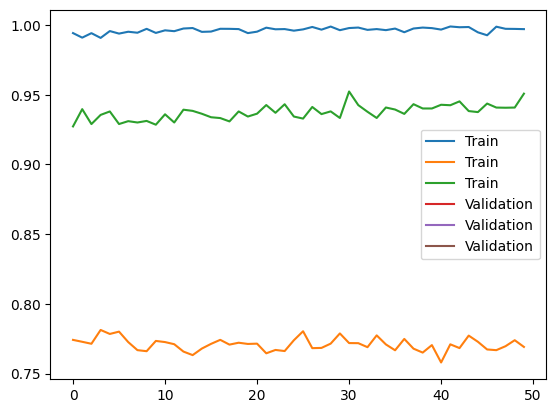

In [51]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [19]:
train_accuracies

[tensor([0.9224, 0.1543, 0.9469]),
 tensor([0.9521, 0.4770, 0.9371]),
 tensor([0.9538, 0.5614, 0.9344]),
 tensor([0.9619, 0.6108, 0.9393]),
 tensor([0.9691, 0.6338, 0.9400]),
 tensor([0.9718, 0.6736, 0.9415]),
 tensor([0.9703, 0.6842, 0.9461]),
 tensor([0.9768, 0.6905, 0.9494]),
 tensor([0.9797, 0.7088, 0.9497]),
 tensor([0.9810, 0.7159, 0.9546]),
 tensor([0.9794, 0.7087, 0.9520]),
 tensor([0.9842, 0.7209, 0.9523]),
 tensor([0.9843, 0.7234, 0.9616]),
 tensor([0.9839, 0.7193, 0.9631]),
 tensor([0.9896, 0.7244, 0.9565]),
 tensor([0.9853, 0.7214, 0.9601]),
 tensor([0.9889, 0.7240, 0.9624]),
 tensor([0.9890, 0.7234, 0.9642]),
 tensor([0.9931, 0.7249, 0.9616]),
 tensor([0.9928, 0.7241, 0.9693]),
 tensor([0.9936, 0.7154, 0.9641]),
 tensor([0.9934, 0.7238, 0.9638]),
 tensor([0.9940, 0.7176, 0.9666]),
 tensor([0.9949, 0.7255, 0.9706]),
 tensor([0.9977, 0.7201, 0.9656]),
 tensor([0.9948, 0.7209, 0.9635]),
 tensor([0.9959, 0.7192, 0.9653]),
 tensor([0.9945, 0.7203, 0.9656]),
 tensor([0.9939, 0.7

In [20]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

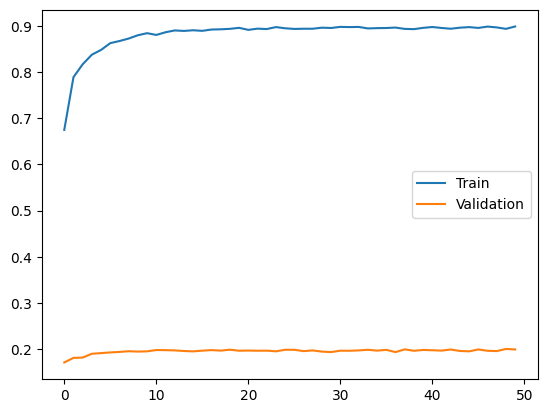

In [21]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()

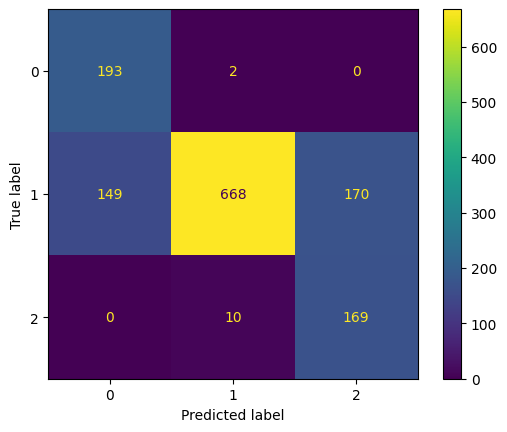

In [22]:
conf_matrix_val = confusion_matrix(val_dataset_classify.label, predicted_argmax_val)
ConfusionMatrixDisplay(conf_matrix_val).plot()
plt.show()

In [23]:
f1_score(val_dataset_classify.label, predicted_argmax_val, average="micro")

0.7567964731814842